In [2]:
import os
import numpy as np

import fiona
import rasterio
import rasterio.mask
from rasterio.windows import Window

import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colors

import torch

# Project and Control polygons

In [71]:
path = "../data/raw/car/acre/"
folders = [name for name in os.listdir(path) if "SHAPE" in name]
df = gpd.GeoDataFrame()
for folder in folders:
    df_new = gpd.read_file(path + folder + "/AREA_IMOVEL/AREA_IMOVEL.shp")
    df = pd.concat([df, df_new])

In [207]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
path_pa = "../data/raw/pa/ValparaisoProperty (Kml).kml"
pa = gpd.read_file(path_pa, driver='KML')
pa = pa.to_crs("EPSG:4674")

In [73]:
df['area_6933'] = df.geometry.to_crs("EPSG:6933").area
print('Total shape files: ', df.shape[0])

pa_area = pa.to_crs("EPSG:6933").area.sum()
df = df[(df.area_6933 > 0.75 * pa_area) & (df.area_6933 < 1.25 * pa_area)]
print('Area filtered shape files: ', df.shape[0])

for polygon in pa.geometry:
    df = df[np.invert(df.overlaps(polygon).values)]
print('Overlapping filtered shape files: ', df.shape[0])

unobserved = 255
forest_cover_1985 = []
for car in df.iterrows():
    bio_data = torch.load("../data/processed/biomass/30m/biomass_1985.pt").numpy()
    forest_cover = np.count_nonzero(bio_data == 0) / np.count_nonzero(bio_data < unobserved)
    forest_cover_1985.append(forest_cover)
df['fc_1985'] = forest_cover_1985
df = df[df.fc_1985 >= 0.9]
print('Sufficiently covered with forest: ', df.shape[0])

Total shape files:  41902
Area filtered shape files:  39
Overlapping filtered shape files:  38


/opt/homebrew/Caskroom/miniforge/base/envs/sp/lib/python3.9/site-packages/shapely/predicates.py:853: RuntimeWarning: invalid value encountered in overlaps
  return lib.overlaps(a, b, **kwargs)


Sufficiently covered with forest:  38


<Axes: >

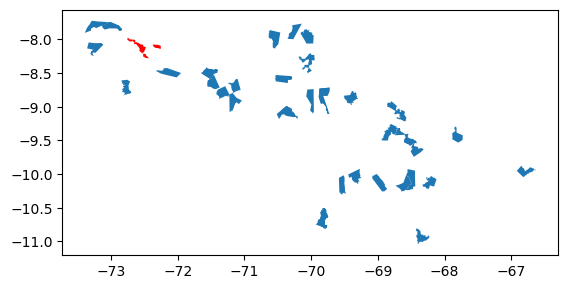

In [74]:
fig, ax = plt.subplots()
df.plot(ax=ax)
pa.plot(ax=ax, color='red')

# Preprocess data

In [360]:
pa = pa.to_crs("EPSG:6933")

In [361]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

resolution = 250
dst_crs = 'EPSG:6933'

for year in range(1985,2021+1):
    path_bio = f"../data/raw/biomass/{resolution}m/" + f"mapbiomas-brazil-collection-70-acre-{year}.tif"
    with rasterio.open(path_bio) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(f"../data/processed/biomass/{resolution}m_6933/" + f"biomass_{year}.tif", 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [321]:
# function to load biomass data
def load_biomass_data(year, shape, resolution=250):
    path_bio = f"../data/processed/biomass/{resolution}m_6933/" + f"biomass_{year}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    return bio_data, out_meta

# function to transform labels to 1=forest, 2=non_forest, 0=unknown
def transform_to_labels(bio_data):
    class_dict = {1:0, 3:0, 4:0, 5:0,49:0, # forest
                10:1,11:1,12:1,32:1,29:1,13:1, 13:1, 50:1, # natural
                14:2,15:2,18:2,19:2,39:2,20:2,40:2,61:2,41:2,36:2,46:2,47:2,48:2,9:2,21:2, # farming
                22:3,23:3,24:3,30:3,25:3, # urban
                26:4,33:4,31:4, # water
                27:255,0:255} # unobserved
    bio_data_new = np.zeros_like(bio_data)
    for key, value in class_dict.items():
        bio_data_new[bio_data == key] = value
    return bio_data_new

def preprocess_data(path_bio_processed):
    all_years = np.range(1985,2022)

    bio_data = []
    out_meta = []
    for year in all_years:
        bio_data_year, out_meta_year = load_biomass_data(year, None, resolution=resolution)
        bio_data_year = transform_to_labels(bio_data_year)
        bio_data.append(bio_data_year)
        out_meta.append(out_meta_year)

    # replace unobserved with previously observed
    for i in np.arange(1, len(bio_data)):
        previously_observed = (bio_data[i] == 255) & (bio_data[i-1] != 255)
        bio_data[i][previously_observed] = bio_data[i-1][previously_observed]

    # identify mask to changing labels
    mask = bio_data[0] == 255
    for i in np.arange(1, len(bio_data)):
        mask = mask | ((bio_data[i-1] == 2) & (bio_data[i] == 0)) # mask pixels water -> forest
        mask = mask | ((bio_data[i-1] == 0) & (bio_data[i] == 2)) # mask pixels forest -> water

        if i > 1: # mask forest <-> not forest <-> forest
            mask = mask | ((bio_data[i-2] == 0) & (bio_data[i-1] != 0) & (bio_data[i] == 0)) 

        mask = mask | ((bio_data[i-1] == 1) & (bio_data[i] == 0))  # non-forest -> forest

    with rasterio.open(path_bio_processed + "biomass_mask.tif", "w", **out_meta[0]) as dest:
        dest.write(np.expand_dims(mask, axis=0))

    # save
    for i, year in enumerate(all_years):
        with rasterio.open(path_bio_processed + f"biomass_{year}.tif", "w", **out_meta[i]) as dest:
            dest.write(np.expand_dims(bio_data[i], axis=0))

In [322]:
resolution = 250
path_bio_processed = f"../data/processed/biomass/{resolution}m_6933/"
preprocess_data(path_bio_processed)

In [323]:
# function to load biomass data
def load_processed_biomass_data(year, shape, resolution=250):
    path_bio = f"../data/processed/biomass/{resolution}m_6933/" + f"biomass_{year}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        if shape is not None:
            nodata = 255 if year != "mask" else 1
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
            bio_data = bio_data.squeeze()
            out_meta.update({"driver": "GTiff",
                 "height": bio_data.shape[0],
                 "width": bio_data.shape[1],
                 "transform": out_transform})
        else:
            bio_data = src.read(1)
    bio_data = bio_data if year != "mask" else bio_data.astype(bool)
    return bio_data, out_meta

In [324]:
year = 2011
bio_data, bio_data_meta = load_processed_biomass_data(year, pa.geometry, resolution=250)

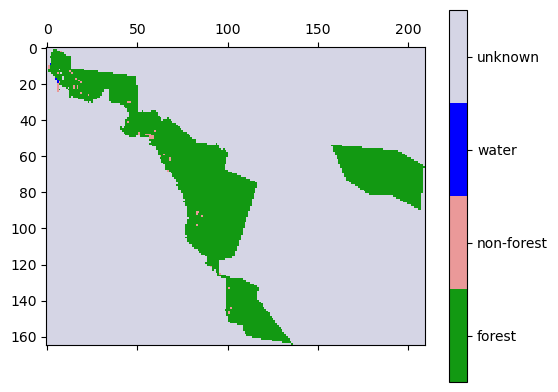

In [325]:
cmap = colors.ListedColormap(['#129912','#ea9999', 'blue', '#D5D5E5'])
mat = plt.matshow(bio_data,cmap=cmap,vmin = -.5, vmax = 3.5)
cax = plt.colorbar(mat, ticks=np.arange(0,4))
cax.ax.set_yticklabels(['forest', 'non-forest', 'water', 'unknown'])
plt.show()

# Calculate deforestation rate

In [326]:
pa = pa.to_crs("EPSG:6933")

start_date = 2011
end_date = 2017
unobserved = 255
resolution = 250
bio_data_2011, bio_data_meta = load_processed_biomass_data(start_date, pa.geometry, resolution=resolution)
bio_data_2017, bio_data_meta = load_processed_biomass_data(end_date, pa.geometry, resolution=resolution)
mask, mask_meta = load_processed_biomass_data("mask", pa.geometry, resolution=resolution)
bio_data_2011_masked = bio_data_2011.copy()
bio_data_2011_masked[mask] = 255
bio_data_2017_masked = bio_data_2017.copy()
bio_data_2017_masked[mask] = 255

In [327]:
bio_data_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 210,
 'height': 165,
 'count': 1,
 'crs': CRS.from_epsg(6933),
 'transform': Affine(233.6414038876932, 0.0, -7020287.845857723,
        0.0, -233.6414038876932, -1014847.8496158166)}

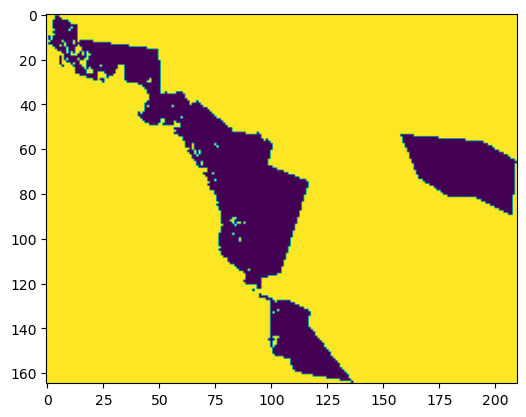

In [328]:
plt.imshow(mask)

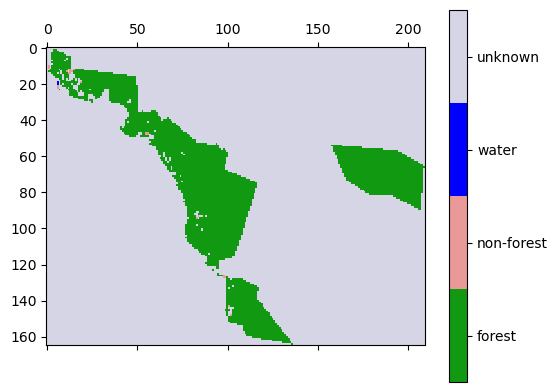

In [329]:
cmap = colors.ListedColormap(['#129912','#ea9999', 'blue', '#D5D5E5'])
mat = plt.matshow(bio_data_2017_masked,cmap=cmap,vmin = -.5, vmax = 3.5)
cax = plt.colorbar(mat, ticks=np.arange(0,4))
cax.ax.set_yticklabels(['forest', 'non-forest', 'water', 'unknown'])
plt.show()

In [330]:
forest_cover_2011 = np.count_nonzero(bio_data_2011 == 0) / np.count_nonzero(bio_data_2011 < 255)
forest_cover_2017 = np.count_nonzero(bio_data_2017 == 0) / np.count_nonzero(bio_data_2017 < 255)
resolution_new = np.sqrt(pa_area / np.count_nonzero(bio_data_2011 < 255))
pa_area_pixel = np.count_nonzero(bio_data_2011 < 255) * resolution_new**2
print("PA area - polygon", pa_area) # 28,988
print("PA area - pixel", pa_area_pixel)
print("Resolution est.", resolution_new)

print("---- 2011 ----")
forest_cover_2011_ha = pa_area_pixel * forest_cover_2011
print("Forest_cover %", forest_cover_2011) # 0,98899544639161
print("Forest cover ha", forest_cover_2011_ha/10000) #28,669

print("---- 2017 ----")
forest_cover_2017_ha = pa_area_pixel * forest_cover_2017
print("Forest_cover %", forest_cover_2017) # 0,98899544639161
print("Forest cover ha", forest_cover_2017_ha/10000)
print("Cummulative deforestation", (forest_cover_2011_ha - forest_cover_2017_ha)/10000)
print("Percent lost",  forest_cover_2011 - forest_cover_2017)

PA area - polygon 289886589.1948548
PA area - pixel 289886589.1948548
Resolution est. 233.7386004867241
---- 2011 ----
Forest_cover % 0.9894459102902374
Forest cover ha 28682.71001268352
---- 2017 ----
Forest_cover % 0.9817188088955899
Forest cover ha 28458.711705917805
Cummulative deforestation 223.99830676571727
Percent lost 0.007727101394647495


In [331]:
forest_cover_2011_ha = np.count_nonzero(bio_data_2011_masked == 0) * resolution_new**2 /10000
forest_cover_2017_ha = np.count_nonzero(bio_data_2017_masked == 0) * resolution_new**2 /10000
print(forest_cover_2011_ha)
print(forest_cover_2017_ha)

28070.812199079603
27988.86159904337


In [333]:
bio_data = {}
bio_data_masked = {}
for year in np.arange(1985, 2021+1):
    bio_data_year, _ = load_processed_biomass_data(year, pa.geometry, resolution=resolution)
    bio_data_masked_year = bio_data_year.copy()
    bio_data_masked_year[mask] = 255
    bio_data[year] = bio_data_year
    bio_data_masked[year] = bio_data_masked_year

In [355]:
deforestation = []
for year in np.arange(1985+1, 2019+1):
    defores_px = np.count_nonzero((bio_data[year-1] == 0) & (bio_data[year] == 1) & (bio_data[year+1] == 1))
    deforestation.append(defores_px)

In [356]:
deforestation

[0,
 2,
 2,
 3,
 3,
 0,
 4,
 7,
 3,
 2,
 3,
 2,
 4,
 4,
 5,
 3,
 2,
 6,
 9,
 9,
 5,
 14,
 4,
 8,
 8,
 8,
 8,
 26,
 26,
 5,
 11,
 6,
 8,
 5]

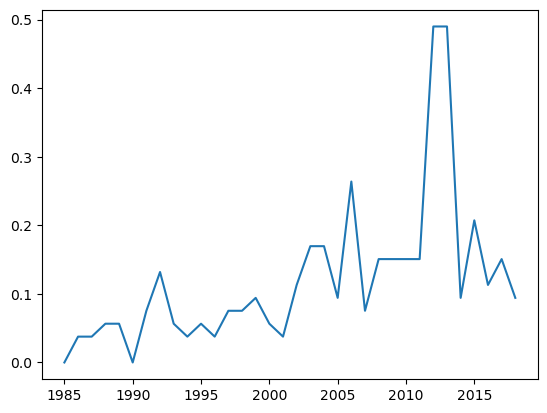

In [358]:
plt.plot(np.arange(1985, 2019), np.array(deforestation)/np.count_nonzero(bio_data_2011 < 255)*100)

In [ ]:
forest_cover_2011 = np.count_nonzero(bio_data_2011 == 0) / np.count_nonzero(bio_data_2011 < 255)
forest_cover_2017 = np.count_nonzero(bio_data_2017 == 0) / np.count_nonzero(bio_data_2017 < 255)
resolution_new = np.sqrt(pa_area / np.count_nonzero(bio_data_2011 < 255))
pa_area_pixel = np.count_nonzero(bio_data_2011 < 255) * resolution_new**2
print("PA area - polygon", pa_area) # 28,988
print("PA area - pixel", pa_area_pixel)
print("Resolution est.", resolution_new)

print("---- 2011 ----")
forest_cover_2011_ha = pa_area_pixel * forest_cover_2011
print("Forest_cover %", forest_cover_2011) # 0,98899544639161
print("Forest cover ha", forest_cover_2011_ha/10000) #28,669

print("---- 2017 ----")
forest_cover_2017_ha = pa_area_pixel * forest_cover_2017
print("Forest_cover %", forest_cover_2017) # 0,98899544639161
print("Forest cover ha", forest_cover_2017_ha/10000)
print("Cummulative deforestation", (forest_cover_2011_ha - forest_cover_2017_ha)/10000)
print("Percent lost",  forest_cover_2011 - forest_cover_2017)

PA area - polygon 289886589.1948548
PA area - pixel 289886589.1948548
Resolution est. 233.7386004867241
---- 2011 ----
Forest_cover % 0.9894459102902374
Forest cover ha 28682.71001268352
---- 2017 ----
Forest_cover % 0.9817188088955899
Forest cover ha 28458.711705917805
Cummulative deforestation 223.99830676571727
Percent lost 0.007727101394647495


In [ ]:
forest_cover_2011 = np.count_nonzero(bio_data_2011 == 0) / np.count_nonzero(bio_data_2011 < 255)
forest_cover_2017 = np.count_nonzero(bio_data_2017 == 0) / np.count_nonzero(bio_data_2017 < 255)
resolution_new = np.sqrt(pa_area / np.count_nonzero(bio_data_2011 < 255))
pa_area_pixel = np.count_nonzero(bio_data_2011 < 255) * resolution_new**2
print("PA area - polygon", pa_area) # 28,988
print("PA area - pixel", pa_area_pixel)
print("Resolution est.", resolution_new)

print("---- 2011 ----")
forest_cover_2011_ha = pa_area_pixel * forest_cover_2011
print("Forest_cover %", forest_cover_2011) # 0,98899544639161
print("Forest cover ha", forest_cover_2011_ha/10000) #28,669

print("---- 2017 ----")
forest_cover_2017_ha = pa_area_pixel * forest_cover_2017
print("Forest_cover %", forest_cover_2017) # 0,98899544639161
print("Forest cover ha", forest_cover_2017_ha/10000)
print("Cummulative deforestation", (forest_cover_2011_ha - forest_cover_2017_ha)/10000)
print("Percent lost",  forest_cover_2011 - forest_cover_2017)

PA area - polygon 289886589.1948548
PA area - pixel 289886589.1948548
Resolution est. 233.7386004867241
---- 2011 ----
Forest_cover % 0.9894459102902374
Forest cover ha 28682.71001268352
---- 2017 ----
Forest_cover % 0.9817188088955899
Forest cover ha 28458.711705917805
Cummulative deforestation 223.99830676571727
Percent lost 0.007727101394647495


In [ ]:
forest_cover_2011 = np.count_nonzero(bio_data_2011 == 0) / np.count_nonzero(bio_data_2011 < 255)
forest_cover_2017 = np.count_nonzero(bio_data_2017 == 0) / np.count_nonzero(bio_data_2017 < 255)
resolution_new = np.sqrt(pa_area / np.count_nonzero(bio_data_2011 < 255))
pa_area_pixel = np.count_nonzero(bio_data_2011 < 255) * resolution_new**2
print("PA area - polygon", pa_area) # 28,988
print("PA area - pixel", pa_area_pixel)
print("Resolution est.", resolution_new)

print("---- 2011 ----")
forest_cover_2011_ha = pa_area_pixel * forest_cover_2011
print("Forest_cover %", forest_cover_2011) # 0,98899544639161
print("Forest cover ha", forest_cover_2011_ha/10000) #28,669

print("---- 2017 ----")
forest_cover_2017_ha = pa_area_pixel * forest_cover_2017
print("Forest_cover %", forest_cover_2017) # 0,98899544639161
print("Forest cover ha", forest_cover_2017_ha/10000)
print("Cummulative deforestation", (forest_cover_2011_ha - forest_cover_2017_ha)/10000)
print("Percent lost",  forest_cover_2011 - forest_cover_2017)

PA area - polygon 289886589.1948548
PA area - pixel 289886589.1948548
Resolution est. 233.7386004867241
---- 2011 ----
Forest_cover % 0.9894459102902374
Forest cover ha 28682.71001268352
---- 2017 ----
Forest_cover % 0.9817188088955899
Forest cover ha 28458.711705917805
Cummulative deforestation 223.99830676571727
Percent lost 0.007727101394647495


In [ ]:
forest_cover_2011 = np.count_nonzero(bio_data_2011 == 0) / np.count_nonzero(bio_data_2011 < 255)
forest_cover_2017 = np.count_nonzero(bio_data_2017 == 0) / np.count_nonzero(bio_data_2017 < 255)
resolution_new = np.sqrt(pa_area / np.count_nonzero(bio_data_2011 < 255))
pa_area_pixel = np.count_nonzero(bio_data_2011 < 255) * resolution_new**2
print("PA area - polygon", pa_area) # 28,988
print("PA area - pixel", pa_area_pixel)
print("Resolution est.", resolution_new)

print("---- 2011 ----")
forest_cover_2011_ha = pa_area_pixel * forest_cover_2011
print("Forest_cover %", forest_cover_2011) # 0,98899544639161
print("Forest cover ha", forest_cover_2011_ha/10000) #28,669

print("---- 2017 ----")
forest_cover_2017_ha = pa_area_pixel * forest_cover_2017
print("Forest_cover %", forest_cover_2017) # 0,98899544639161
print("Forest cover ha", forest_cover_2017_ha/10000)
print("Cummulative deforestation", (forest_cover_2011_ha - forest_cover_2017_ha)/10000)
print("Percent lost",  forest_cover_2011 - forest_cover_2017)

PA area - polygon 289886589.1948548
PA area - pixel 289886589.1948548
Resolution est. 233.7386004867241
---- 2011 ----
Forest_cover % 0.9894459102902374
Forest cover ha 28682.71001268352
---- 2017 ----
Forest_cover % 0.9817188088955899
Forest cover ha 28458.711705917805
Cummulative deforestation 223.99830676571727
Percent lost 0.007727101394647495


In [ ]:
forest_cover_2011 = np.count_nonzero(bio_data_2011 == 0) / np.count_nonzero(bio_data_2011 < 255)
forest_cover_2017 = np.count_nonzero(bio_data_2017 == 0) / np.count_nonzero(bio_data_2017 < 255)
resolution_new = np.sqrt(pa_area / np.count_nonzero(bio_data_2011 < 255))
pa_area_pixel = np.count_nonzero(bio_data_2011 < 255) * resolution_new**2
print("PA area - polygon", pa_area) # 28,988
print("PA area - pixel", pa_area_pixel)
print("Resolution est.", resolution_new)

print("---- 2011 ----")
forest_cover_2011_ha = pa_area_pixel * forest_cover_2011
print("Forest_cover %", forest_cover_2011) # 0,98899544639161
print("Forest cover ha", forest_cover_2011_ha/10000) #28,669

print("---- 2017 ----")
forest_cover_2017_ha = pa_area_pixel * forest_cover_2017
print("Forest_cover %", forest_cover_2017) # 0,98899544639161
print("Forest cover ha", forest_cover_2017_ha/10000)
print("Cummulative deforestation", (forest_cover_2011_ha - forest_cover_2017_ha)/10000)
print("Percent lost",  forest_cover_2011 - forest_cover_2017)

PA area - polygon 289886589.1948548
PA area - pixel 289886589.1948548
Resolution est. 233.7386004867241
---- 2011 ----
Forest_cover % 0.9894459102902374
Forest cover ha 28682.71001268352
---- 2017 ----
Forest_cover % 0.9817188088955899
Forest cover ha 28458.711705917805
Cummulative deforestation 223.99830676571727
Percent lost 0.007727101394647495


In [310]:
np.sum(deforestation) * resolution_new**2 / 10000

163.90120007247728

In [246]:
np.count_nonzero(bio_data_2011 < 255)

5306

In [244]:
np.count_nonzero(bio_data_2017 == 0)

5209